In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [3]:
def process_raw_file(input_filename,output_filename):
    with open(input_filename, 'r') as raw:
        with open(output_filename,'w') as output:
            output.write('user_id,ratings,date,movie_id\n')
            movie_id = 'init'
            for line in raw :
                if ':' in line : movie_id = line[:-2]
                else :
                    to_write = line[:-1] + ',' + movie_id + '\n'
                    output.write(to_write)

In [4]:
files = glob.glob('../data/raw/combined*')

for i,file in enumerate(files):
    output_filename = f'../data/processed/training{i}.csv'
    process_raw_file(file,output_filename)

In [2]:
df = pd.read_csv('../data/processed/training0.csv',dtype={'user_id':'int32','ratings':'int8','date':'object','movie_id':'int32'})
df['date'] = pd.to_datetime(df['date'])
df.head()

,user_id,ratings,date,movie_id
0,2532865,4,2005-07-26,4500
1,573364,3,2005-06-20,4500
2,1696725,3,2004-02-27,4500
3,1253431,3,2004-03-31,4500
4,1265574,2,2003-09-01,4500


## I - Dropping data

In [67]:
# There's too much data to pivot the table, we need to discard the movies that are the least seen

# We normalise the views by the time the movie has been on the platform (in days)
# That will be our movie importance value
movie_views = df.groupby('movie_id').agg({'user_id':'count','date':'min'}).rename(columns={'user_id':'view_count','date':'release_date'}).reset_index()
movie_views['time_available'] = df['date'].max() - movie_views['release_date']
movie_views['time_available'] = movie_views['time_available'].apply(lambda x : x.days)
movie_views['view_count_norm'] = movie_views['view_count'] / movie_views['time_available'].astype('int')

# Starting with the movie that's the most successful in terms of normalised view, we count how many views remain
# if we were to drop all the movies below (cumsum) and later compute the % in terms of all the views
movie_views = movie_views.sort_values('view_count_norm',ascending=False)
movie_views = movie_views.reset_index().drop(columns='index').reset_index()
movie_views['views_left'] = movie_views['view_count'].cumsum()

# Similarily we count how many movies are left in % (we wan't to compare how many views left with how many movies left)
movie_views['movie_left_perc'] = (movie_views['index'] + 1) / (movie_views['index'].max() + 1)
movie_views['views_left_perc'] = movie_views['views_left'] / movie_views['view_count'].sum()
movie_views = movie_views.sort_values('view_count_norm')
movie_views.head()

,index,movie_id,view_count,release_date,time_available,view_count_norm,views_left,movie_left_perc,views_left_perc
4710,4710,6393,61,2000-04-05,2096,0.029103,26977591,1.000000,1.000000
4709,4709,6217,64,2000-03-04,2128,0.030075,26977530,0.999788,0.999998
4708,4708,6425,68,2000-01-06,2186,0.031107,26977466,0.999575,0.999995
4707,4707,7842,56,2001-02-12,1783,0.031408,26977398,0.999363,0.999993
4706,4706,6765,67,2000-03-04,2128,0.031485,26977342,0.999151,0.999991


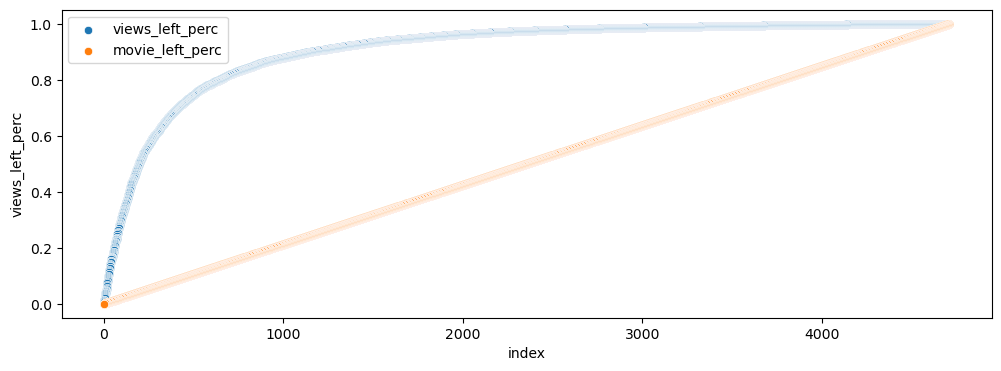

In [73]:
# We want to drop as many movies as possible and lose as less views as possible
# On the first plot, we are looking for the biggest distance between views left and movie left
# Given how we set our index, we are dropping movies from right to left
fig, axs = plt.subplots(1,1,figsize = (12,4))
sns.scatterplot(data=movie_views, x='index' ,y='views_left_perc',ax=axs)
sns.scatterplot(data=movie_views, x='index' ,y='movie_left_perc',ax=axs)
axs.legend(['views_left_perc','movie_left_perc'])

In [83]:
movie_views['diff_views_movie'] = movie_views['views_left_perc'] - movie_views['movie_left_perc']
movies_to_drop = movie_views.iloc[:movie_views['diff_views_movie'].argmax()]['movie_id']

In [3]:
def compress_data(df):
    '''
    Reduce amount of movies
    Finds the optimum between :
    - Deletting as many movies as possible
    - Keeping as many views as possible
    Ranks movies by importance in terms of average of daily views
    '''

    # We normalise the views by the time the movie has been on the platform (in days)
    # That will be our movie importance value
    movie_views = df.groupby('movie_id').agg({'user_id':'count','date':'min'}).rename(columns={'user_id':'view_count','date':'release_date'}).reset_index()
    movie_views['time_available'] = df['date'].max() - movie_views['release_date']
    movie_views['time_available'] = movie_views['time_available'].apply(lambda x : x.days)
    movie_views['view_count_norm'] = movie_views['view_count'] / movie_views['time_available'].astype('int')

    # Starting with the movie that's the most successful in terms of normalised view, we count how many views remain
    # if we were to drop all the movies below (cumsum) and later compute the % in terms of all the views
    movie_views = movie_views.sort_values('view_count_norm',ascending=False)
    movie_views = movie_views.reset_index().drop(columns='index').reset_index()
    movie_views['views_left'] = movie_views['view_count'].cumsum()

    # Similarily we count how many movies are left in % (we wan't to compare how many views left with how many movies left)
    movie_views['movie_left_perc'] = (movie_views['index'] + 1) / (movie_views['index'].max() + 1)
    movie_views['views_left_perc'] = movie_views['views_left'] / movie_views['view_count'].sum()
    movie_views = movie_views.sort_values('view_count_norm')

    # Find the difference between views left (%) and movies left (%)
    movie_views['diff_views_movie'] = movie_views['views_left_perc'] - movie_views['movie_left_perc']
    # Find the maximum of this difference and remove everything up to it
    movies_to_drop = movie_views.iloc[:movie_views['diff_views_movie'].argmax()]['movie_id']
    print('Statistics')
    print(movie_views.iloc[movie_views['diff_views_movie'].argmax()][['movie_left_perc','views_left_perc']])
    del movie_views
    return df.set_index('movie_id').drop(movies_to_drop).reset_index().copy()

## II - Similarities

In [4]:
df = compress_data(df)
df = pd.pivot_table(df,values='ratings',index='user_id',columns='movie_id')
df.head()

Statistics
movie_left_perc    0.185311
views_left_perc    0.859351
Name: 872, dtype: object


movie_id,4506,4507,4520,4522,4531,4533,4545,4546,4561,4570,...,9156,9160,9170,9175,9188,9189,9197,9204,9205,9208
user_id,,,,,,,,,,,,,,,,,,,,,
6,3.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,3.0,3.0,NaN,NaN,NaN,5.0
7,NaN,5.0,4.0,NaN,NaN,NaN,5.0,4.0,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,4.0,NaN,3.0,4.0,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
test1 = pd.DataFrame(np.array([np.nan,2,3]))
test2 = pd.DataFrame(np.array([1,np.nan,2]))
np.dot(test1[0].fillna(0),test2[0].fillna(0))
np.square(test1).sum()

0    13.0
dtype: float64

In [128]:
X_train,X_test = train_test_split(df,test_size=0.0001)
X_test.shape

(48, 873)

In [137]:
def cosine_similarity(user:pd.Series,df:pd.DataFrame)->pd.Series:
    user = user.fillna(0).to_numpy()
    user = user.reshape((1,len(user)))
    user_norm = np.sqrt(np.square(user).sum())
    norm = np.sqrt(np.square(df).sum(axis=1)).to_numpy()
    sim = np.matmul(user,df.T.fillna(0)) / (norm * user_norm)
    return sim

def cosine_similarity_ad(user_a:pd.Series,user_b:pd.Series)->float:
    scalar_prod = np.dot(user_a.fillna(0) - user_a.mean(),user_b.fillna(0)-user_b.mean())
    norm_a = np.sqrt(np.square(user_a-user_a.mean()).sum())
    norm_b = np.sqrt(np.square(user_b-user_b.mean()).sum())
    return (scalar_prod)/(norm_a * norm_b)

In [31]:
def compute_similarity(user,method,df):
    return df.apply(lambda x : method(user, x),axis=1)

In [138]:
def predict_score_mc(user,df):
    '''
    Predic score using the mean-centered formula
    '''
    sim = cosine_similarity(user,df).fillna(0).to_numpy()
    av_score = df.mean().to_numpy()
    av_score = av_score.reshape((1,len(av_score)))
    centered_score = df - df.mean()

    predicted_score = np.matmul(sim,centered_score.fillna(0).to_numpy())
    predicted_score = av_score + (predicted_score / np.abs(sim).sum())
    return pd.DataFrame(predicted_score,columns=df.columns)

In [98]:
def predict_score_ws(sim,df):
    '''
    Predict score using weighted sum
    '''
    scores = []
    for col_name in df.columns :
        col = df[col_name]
        ones = col / col
        score = np.dot(col.fillna(0),sim)
        score = score / (np.dot(ones.fillna(0),sim)).sum()
        scores.append(score)
    return pd.Series(scores,index=df.columns)

In [140]:
maes = []
for idx in tqdm(range(10)):
    user = X_test.iloc[idx]
    scores = predict_score_mc(user,X_train)
    mae = np.abs(scores.iloc[0] - user).mean()
    maes.append(mae)

100%|██████████| 10/10 [04:20<00:00, 26.05s/it]


In [145]:
np.round(maes).mean()

1.2